# Understanding ResNet Memory Footprint
In this notebook, we explore ResNet memory usage and the effect of gradient checkpointing. The following sections demonstrate:
- Installing required libraries
- Loading and preparing the Tiny ImageNet dataset
- Measuring GPU memory usage with varying batch sizes
- Comparing results with and without gradient checkpointing

## Install Dependencies

## Imports and Setup

In [2]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt

from torch.profiler import record_function
from datasets import load_dataset
from torchvision import transforms, models

# Set seed for reproducibility
torch.manual_seed(710)
np.random.seed(710)

# Detect number of available CUDA devices
print(f"Number of CUDA devices: {torch.cuda.device_count()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Number of CUDA devices: 2
Using device: cuda:0


## Load Dataset

In [3]:
tiny_imagenet = load_dataset("Maysee/tiny-imagenet", split="train")
print(f"Sample record: {tiny_imagenet[0]}")
# Number of classes
num_classes = len(tiny_imagenet.features["label"].names)
print(f"Number of classes: {num_classes}")

Sample record: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F4CFCEC47F0>, 'label': 0}
Number of classes: 200


## Prepare PyTorch Dataset

In [4]:
from PIL import Image

class TinyImageNet(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]["image"], self.dataset[idx]["label"]
        x = x.convert("RGB")
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tiny_imagenet_torch = TinyImageNet(tiny_imagenet, transform=transform)
print(f"Sample torch dataset element shape: {tiny_imagenet_torch[0][0].shape}")

Sample torch dataset element shape: torch.Size([3, 224, 224])


## Load Model to GPU

In [5]:
torch.cuda.memory._record_memory_history(max_entries=10000)

model_gpu_usage_before = torch.cuda.memory_allocated(device)
model = models.resnet18(pretrained=True).to(device)
model_gpu_usage_after = torch.cuda.memory_allocated(device)
model_gpu_usage = model_gpu_usage_after - model_gpu_usage_before
print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())}")
print(f"Model GPU usage: {model_gpu_usage / 1024**2:.2f} MB")

del model


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s] 


Number of parameters in the model: 11689512
Model GPU usage: 44.69 MB


## Training and Memory Profiling
The following function trains the model for a few batches while profiling memory usage.

In [6]:
def fit(model, train_loader, val_loader, epochs=1, lr=0.001, break_after_num_batches=None, title=""):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    with torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
        schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
        record_shapes=True,
        with_stack=True,
        profile_memory=True
    ) as prof:
        for epoch in range(epochs):
            for batch_idx, batch in enumerate(train_loader):
                prof.step()
                inputs, labels = batch
                with record_function("to_device"):
                    inputs, labels = inputs.to(device), labels.to(device)
                with record_function("forward"):
                    outputs = model(inputs)
                with record_function("backward"):
                    criterion(outputs, labels).backward()
                with record_function("optimizer_step"):
                    optimizer.step()
                    optimizer.zero_grad()

                if break_after_num_batches is not None and batch_idx >= break_after_num_batches:
                    break

    prof.export_memory_timeline(f"{title}_memory.html", device="cuda:0")

def clear_cuda_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    import gc
    gc.collect()
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

def fit_helper(model_type, dataset, epochs, break_after_num_batches, batch_sizes, num_workers, title):
    for batch_size in batch_sizes:
        if model_type == "resnet18_without_checkpointing":
            model = models.resnet18(pretrained=True)
        elif model_type == "resnet18_with_checkpointing":
            model = ResnetCheckpointed()
        model.to(device)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        oom_break = False
        try:
            fit(model, train_loader, val_loader, epochs=1, break_after_num_batches=break_after_num_batches)
            print(f"Processed for batch size {batch_size}")
        except RuntimeError as e:
            print(f"Runtime error for batch size {batch_size}: {e}")
            oom_break = True
        except torch.cuda.OutOfMemoryError:
            print(f"Out of memory for batch size {batch_size}")
            oom_break = True

        del model
        del train_loader
        del val_loader
        clear_cuda_memory()
        time.sleep(5)
        if oom_break:
            break

## Run Profiling Without Gradient Checkpointing

Number of workers: 2


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/profiler/profiler.py:406: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


Processed for batch size 128
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 256
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 512
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Runtime error for batch size 1024: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 15.74 GiB of which 346.62 MiB is free. Process 3570611 has 15.39 GiB memory in use. Of the allocated memory 14.42 GiB is allocated by PyTorch, and 832.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Allocated memory: 16.25 MB
Cached memory: 174.00 MB


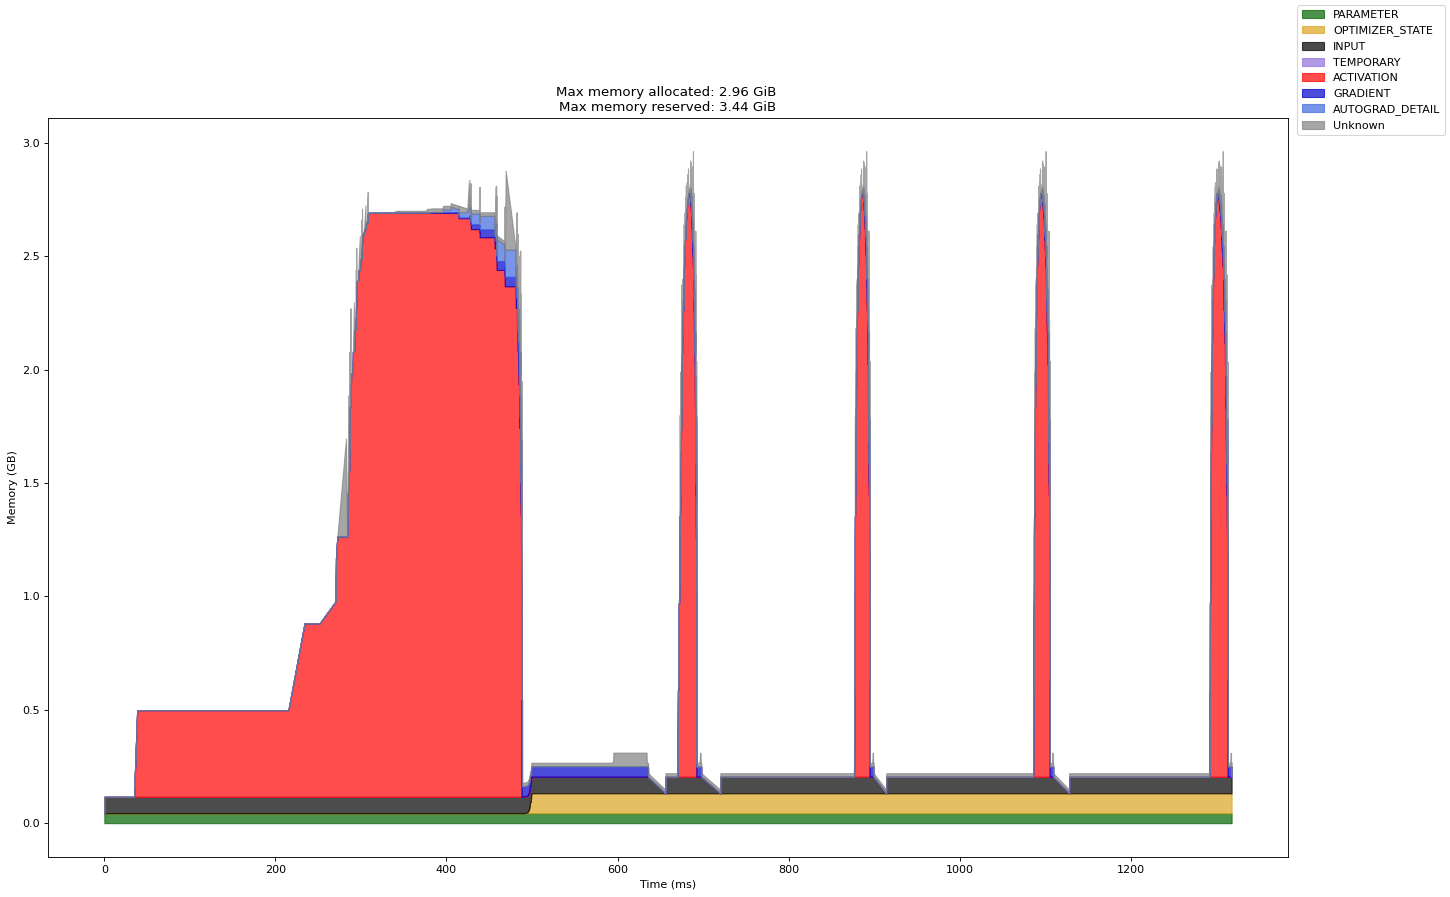

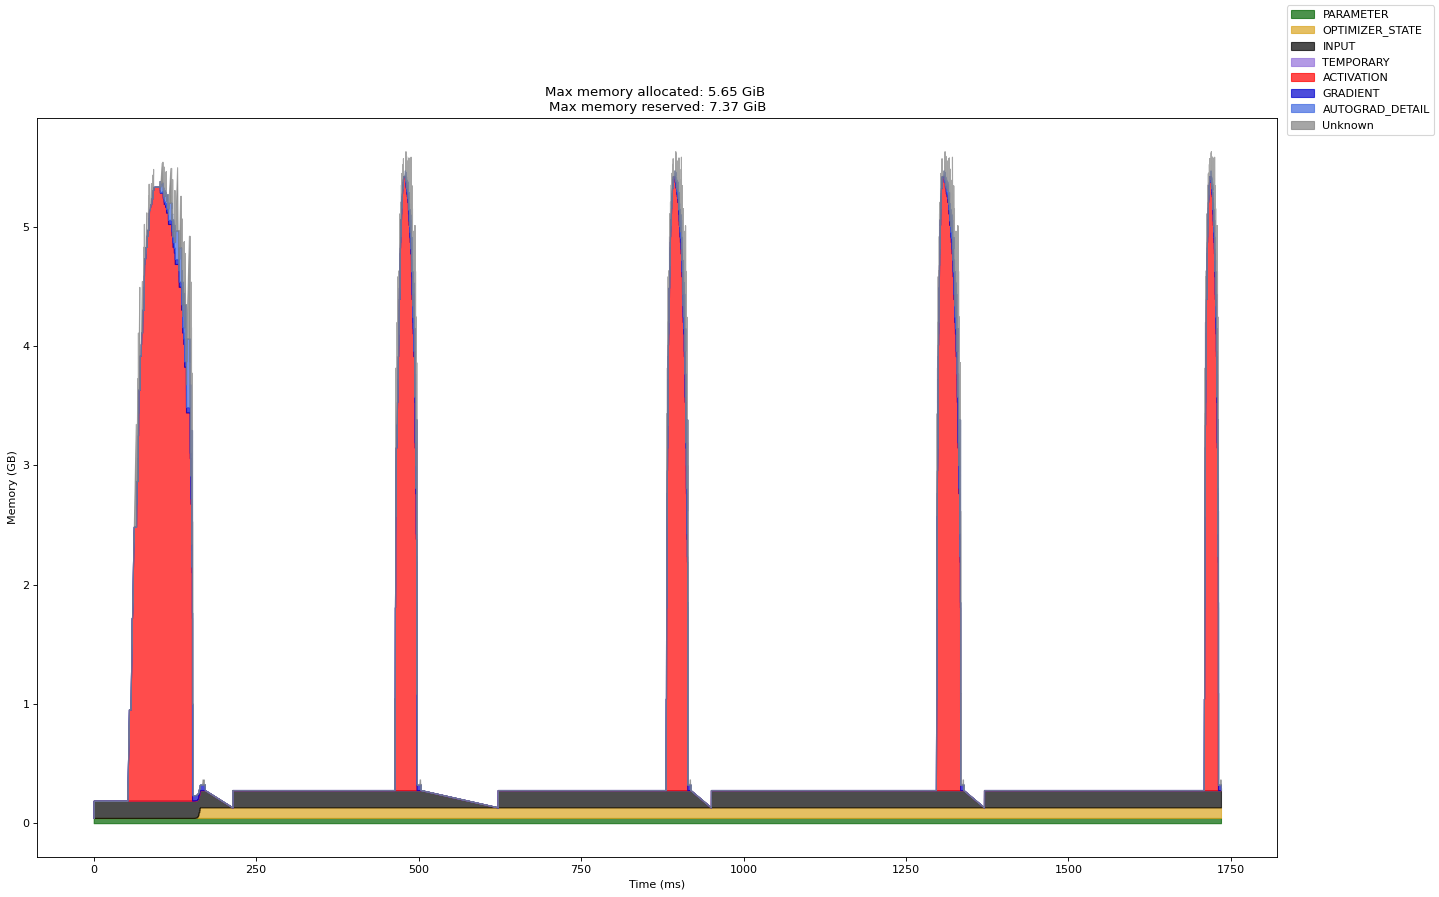

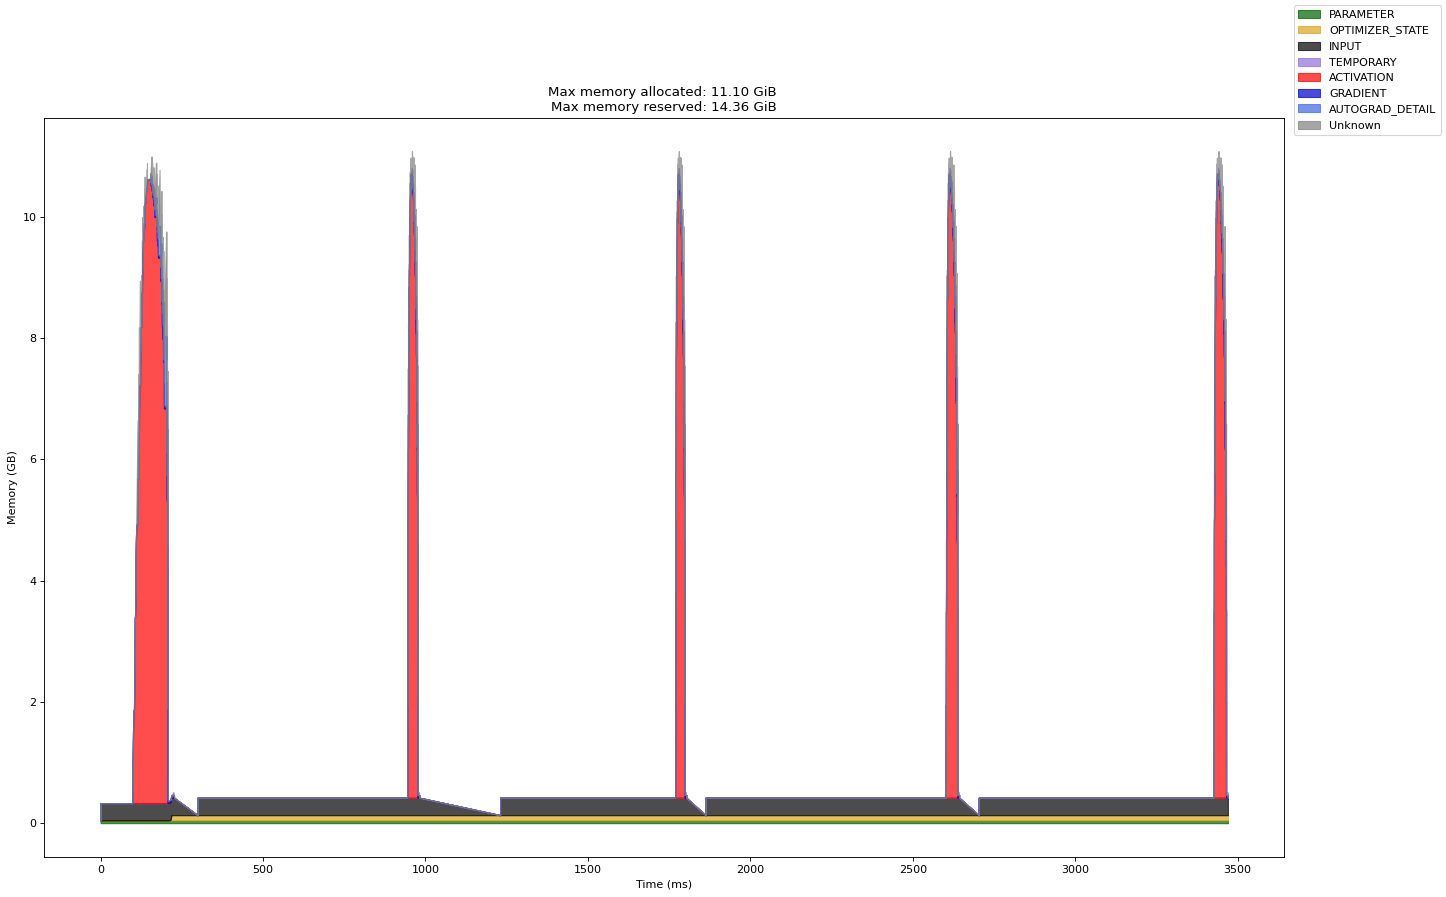

In [7]:
num_workers = 2
print(f"Number of workers: {num_workers}")
break_after_num_batches = 10
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

fit_helper("resnet18_without_checkpointing", tiny_imagenet_torch, 1, break_after_num_batches, batch_sizes, num_workers, title="without_checkpointing")

## Define Model with Gradient Checkpointing

In [8]:
from torch.utils.checkpoint import checkpoint
import torchvision.models as models

class ResnetCheckpointed(nn.Module):
    def __init__(self):
        super(ResnetCheckpointed, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Store individual layers
        self.conv1 = self.model.conv1
        self.bn1 = self.model.bn1
        self.relu = self.model.relu
        self.maxpool = self.model.maxpool
        self.layer1 = self.model.layer1
        self.layer2 = self.model.layer2
        self.layer3 = self.model.layer3
        self.layer4 = self.model.layer4
        self.avgpool = self.model.avgpool
        self.fc = self.model.fc

    def forward(self, x):
        # Apply checkpointing to each layer
        x = checkpoint(self.conv1, x)
        x = checkpoint(self.bn1, x)
        x = self.relu(x)  # ReLU is memory-efficient, no need to checkpoint
        x = checkpoint(self.maxpool, x)
        x = checkpoint(self.layer1, x)
        x = checkpoint(self.layer2, x)
        x = checkpoint(self.layer3, x)
        x = checkpoint(self.layer4, x)
        x = checkpoint(self.avgpool, x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Run Profiling With Gradient Checkpointing

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Processed for batch size 128
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 256
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 512
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 1024
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Processed for batch size 2048
Allocated memory: 16.25 MB
Cached memory: 174.00 MB
Runtime error for batch size 4096: CUDA out of memory. Tried to allocate 12.25 GiB. GPU 0 has a total capacity of 15.74 GiB of which 866.62 MiB is free. Process 3570611 has 14.88 GiB memory in use. Of the allocated memory 14.61 GiB is allocated by PyTorch, and 116.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Allocated memory: 16.25 MB
Cached memo

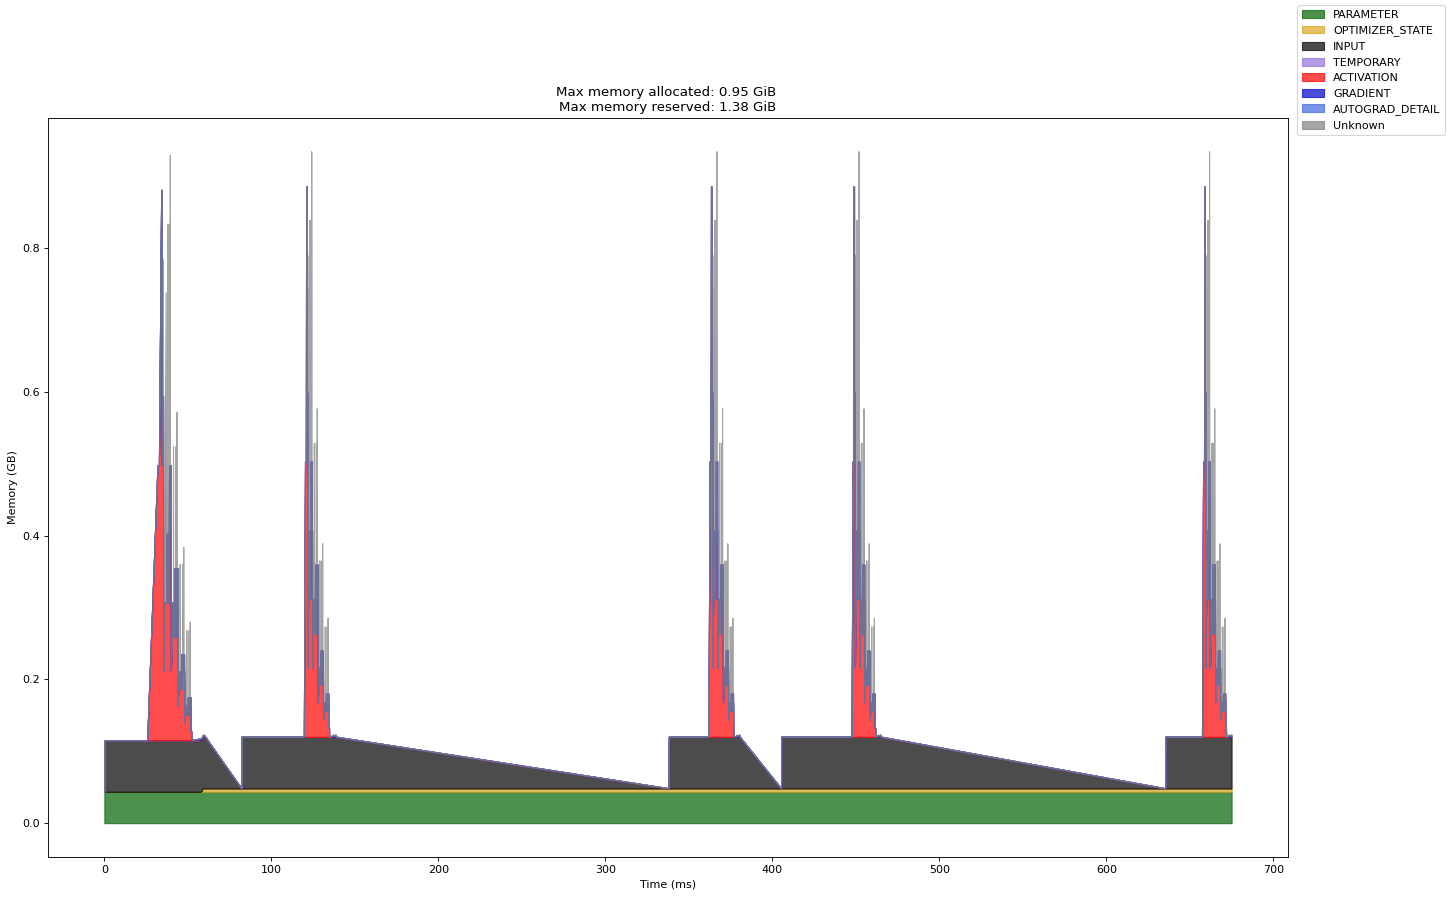

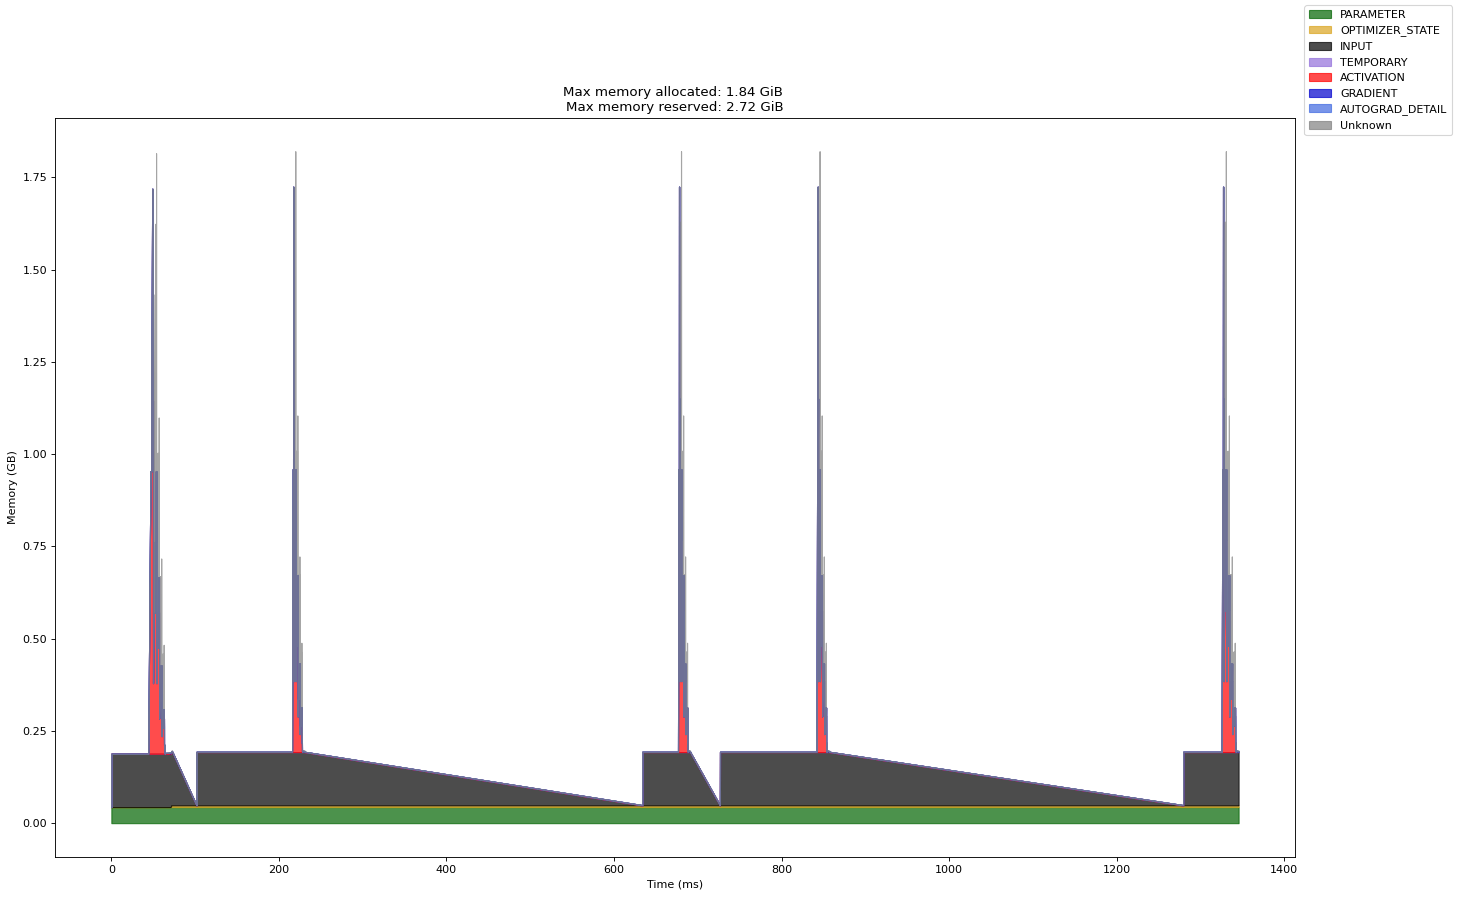

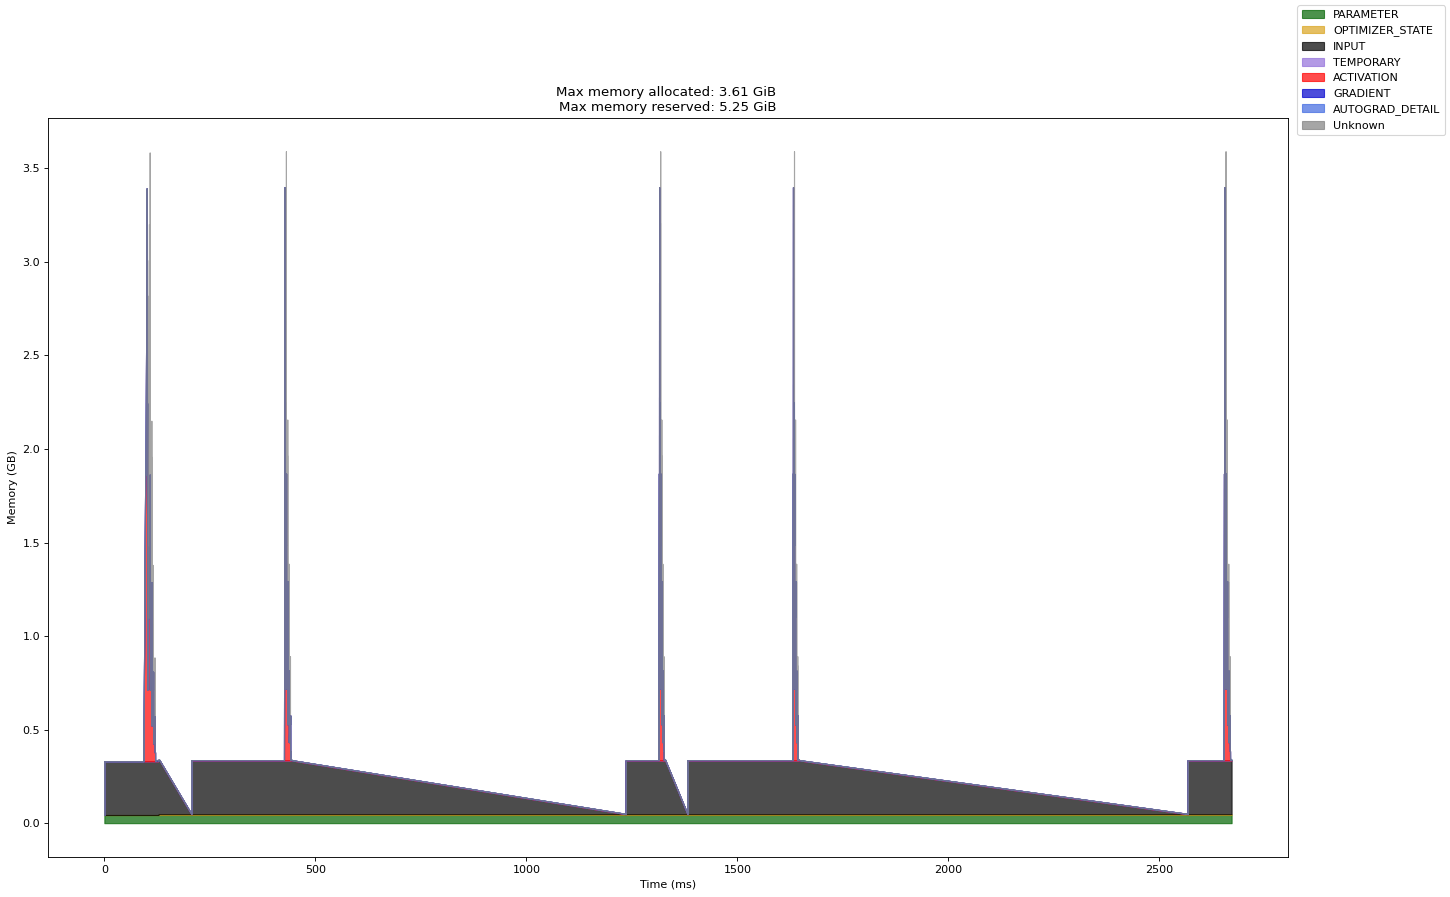

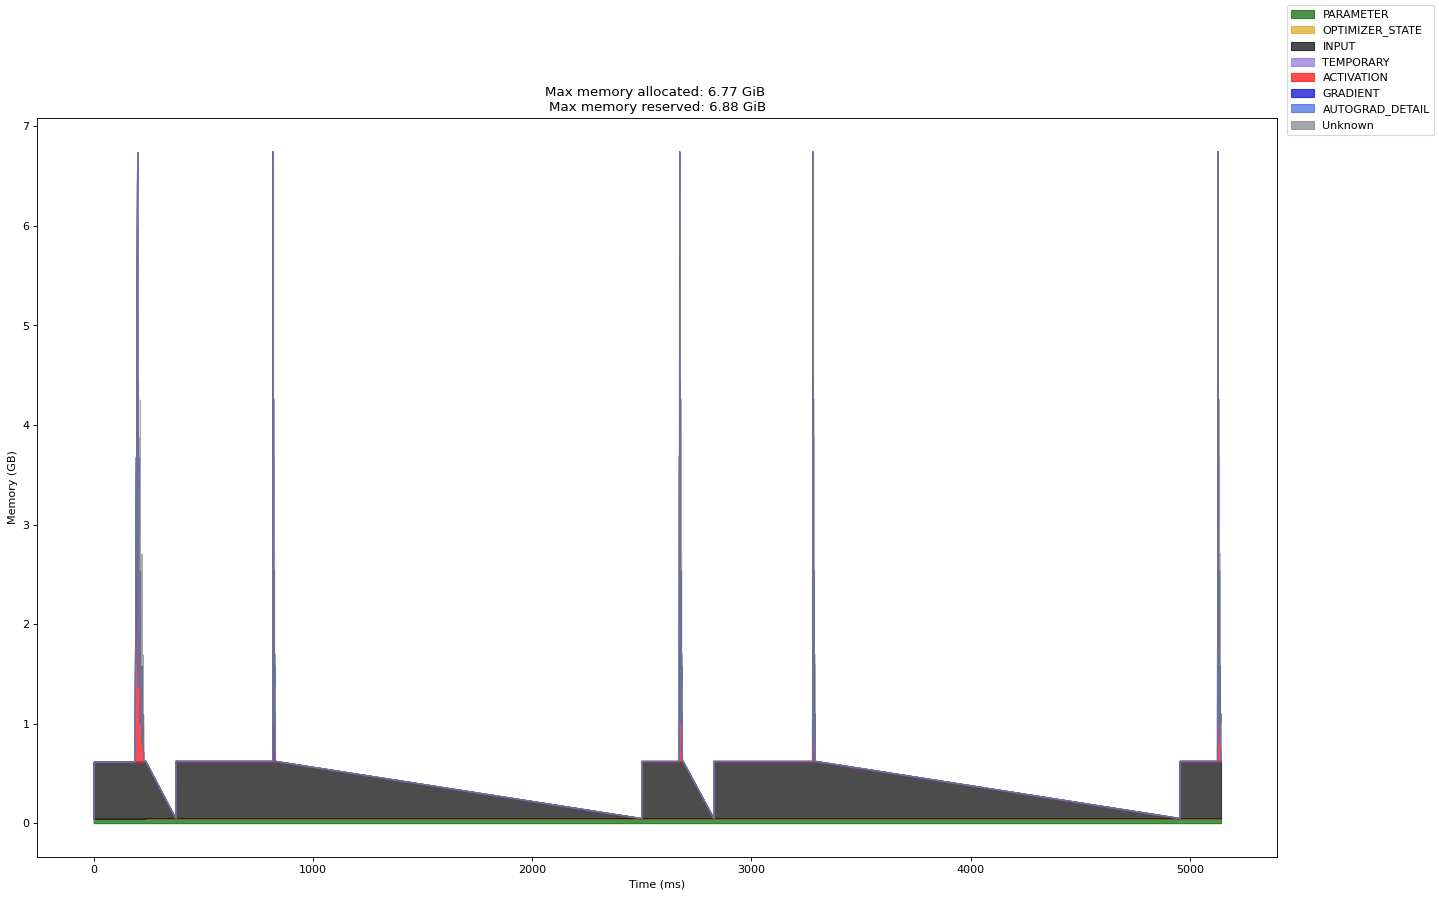

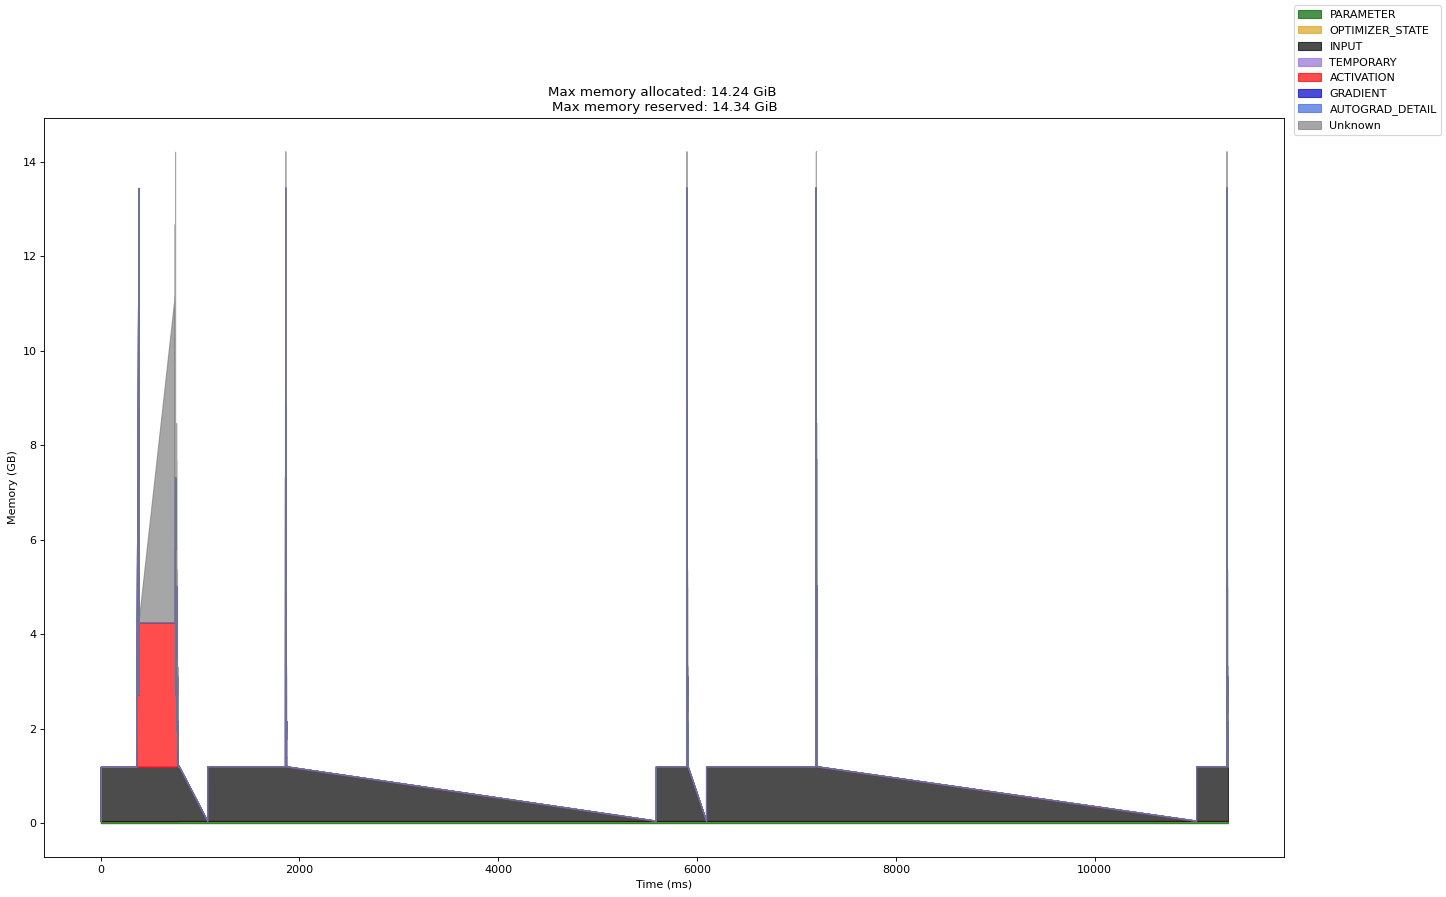

In [9]:
fit_helper("resnet18_with_checkpointing", tiny_imagenet_torch, 1, break_after_num_batches, batch_sizes, num_workers, title="with_checkpointing")

## Conclusions
- Without gradient checkpointing, we were able to fit up to a batch size of 1024 (before running out of memory).
- With gradient checkpointing, we could fit larger batch sizes (up to 4096) in the same GPU.

For memory-intensive tasks, gradient checkpointing can be a useful technique to trade compute for memory.